In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mlflow
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import pipeline
from itertools import product
from scipy.optimize import fmin
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def apply_threshold(predict, threshold):
    pred = predict.copy()
    pred = pred[:,1]
    matching = (pred >= threshold)
    pred[matching] = 1
    pred[~matching] = 0
    return pred

def bank_scoring(y_test, predict):
    confu = confusion_matrix(y_test, predict)
    FP = confu[1,0]
    FN = confu[0,1]
    loss_for_bank = 10*FP + FN
    return loss_for_bank

banklosss = make_scorer(bank_scoring, greater_is_better=False)

def create_test_list(param_list):
    list_param = []
    for i in list(product(*tuple(param_list))):
        list_param.append(list(i))
    return list_param

        
         
    
data_final = pd.read_csv('data_after_featuring.csv').drop(columns = ['Unnamed: 0'])
df_copy = data_final.copy()
X = df_copy.loc[:, (df_copy.columns != 'TARGET')&(df_copy.columns != 'SK_ID_CURR')]
y = df_copy['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y)

sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = (y_train.shape[0]/2)/y_train[y_train == 0].shape[0]
sample_weights[y_train == 1] = (y_train.shape[0]/2)/y_train[y_train == 1].shape[0]

In [3]:
def find_best_threshold(fitted_model, X_test, y_test):
    predictions = fitted_model.predict_proba(X_test)
    
    def loss_with_threshold(threshold):
        predict_thresh = apply_threshold(predictions, threshold)
        loss_for_bank = bank_scoring(y_test, predict_thresh)
        return loss_for_bank
    
    minimum = fmin(loss_with_threshold, 0.5)
    predict_thresh = apply_threshold(predictions, minimum[0])
    acc = accuracy_score(y_test, predict_thresh)
    print(f'For the best threshold {minimum[0]}, the accuracy score is {acc}')
    return minimum[0]

def find_best_threshold2(predictions, y_test):
    
    def loss_with_threshold(threshold):
        predict_thresh = apply_threshold(predictions, threshold)
        loss_for_bank = bank_scoring(y_test, predict_thresh)
        return loss_for_bank
    
    minimum = fmin(loss_with_threshold, 0.5)
    predict_thresh = apply_threshold(predictions, minimum[0])
    acc = accuracy_score(y_test, predict_thresh)
    print(f'For the best threshold {minimum[0]}, the accuracy score is {acc}')
    return predict_thresh
    
def plot_roc_curve(fitted_model, X_test, y_test):
    predictions = fitted_model.predict_proba(X_test)
    preds = predictions[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title(f'ROC curve, AUC = {round(roc_auc, 2)}')
    plt.plot(fpr, tpr)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

{'learning_rate': 0.3, 'max_features': 'sqrt', 'n_estimators': 75}
Optimization terminated successfully.
         Current function value: 42075.000000
         Iterations: 16
         Function evaluations: 35
For the best threshold 0.5189331054687503, the accuracy score is 0.7186804896132784


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


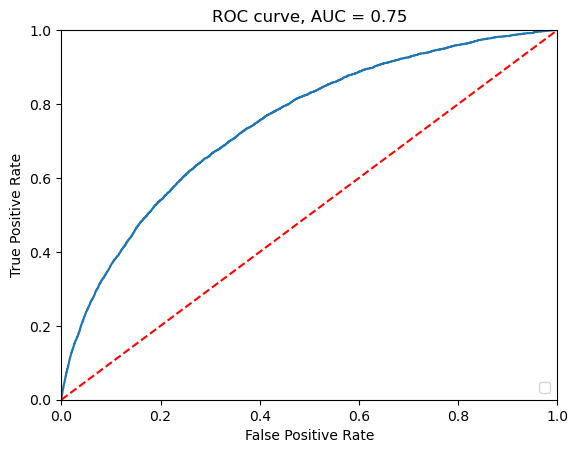

In [71]:
from sklearn.model_selection import GridSearchCV
param = {}
param['learning_rate'] = [0.1,0.3,0.5]
param['n_estimators'] = [20,50,75]
param['max_features'] = ['log2', 'sqrt']

gcv = GridSearchCV(GradientBoostingClassifier(),
                   param,
                   scoring = banklosss,
                   refit = True,
                   cv = 5)
gcv.fit(X_train, y_train, sample_weight = sample_weights)
print(gcv.best_params_)
find_best_threshold(gcv, X_test, y_test)
plot_roc_curve(gcv, X_test, y_test)

{'learning_rate': 0.2, 'max_features': 'sqrt', 'n_estimators': 150}
Optimization terminated successfully.
         Current function value: 41528.000000
         Iterations: 14
         Function evaluations: 29
For the best threshold 0.5011474609375001, the accuracy score is 0.7040207084043342


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


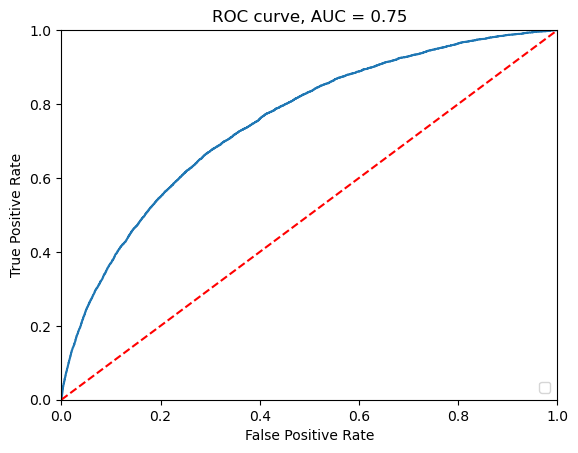

In [72]:
param = {}
param['learning_rate'] = [0.2,0.3,0.4]
param['n_estimators'] = [75,100,150]
param['max_features'] = ['log2','sqrt']

gcv = GridSearchCV(GradientBoostingClassifier(),
                   param,
                   scoring = banklosss,
                   refit = True,
                   cv = 5)
gcv.fit(X_train, y_train, sample_weight = sample_weights)
print(gcv.best_params_)
find_best_threshold(gcv, X_test, y_test)
plot_roc_curve(gcv, X_test, y_test)

{'learning_rate': 0.25, 'max_features': 'sqrt', 'n_estimators': 250}
Optimization terminated successfully.
         Current function value: 40915.000000
         Iterations: 13
         Function evaluations: 29
For the best threshold 0.521875, the accuracy score is 0.7321305461971721


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


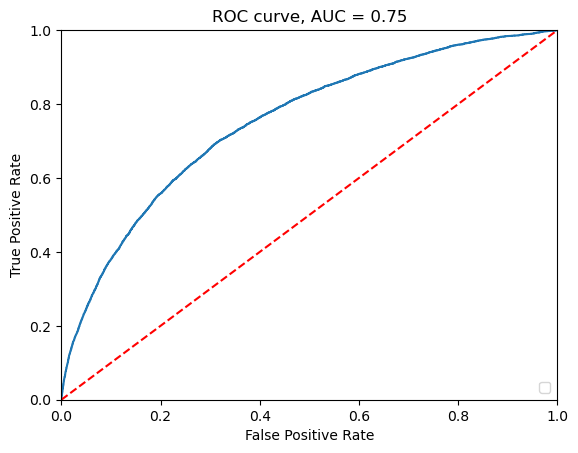

In [4]:
param = {}
param['learning_rate'] = [0.225,0.25,0.275]
param['n_estimators'] = [150,200,250]
param['max_features'] = ['sqrt']

gcv = GridSearchCV(GradientBoostingClassifier(),
                   param,
                   scoring = banklosss,
                   refit = True,
                   cv = 5)
gcv.fit(X_train, y_train, sample_weight = sample_weights)
print(gcv.best_params_)
find_best_threshold(gcv, X_test, y_test)
plot_roc_curve(gcv, X_test, y_test)

In [5]:
gcv.cv_results_

{'mean_fit_time': array([58.63884349, 76.77878118, 94.65326414, 57.55360909, 75.99022717,
        94.11675153, 57.13360515, 78.41954923, 96.25659661]),
 'std_fit_time': array([1.14621433, 0.94521391, 0.59064293, 0.58390044, 0.69801849,
        0.39836623, 0.44001282, 3.41124851, 0.55890945]),
 'mean_score_time': array([0.58414364, 0.6562305 , 0.75692377, 0.54612217, 0.65842938,
        0.81017675, 0.55553107, 0.66143298, 0.75432458]),
 'std_score_time': array([0.02494776, 0.00712433, 0.00643748, 0.01200965, 0.01647662,
        0.07938517, 0.00537187, 0.0263798 , 0.02820116]),
 'param_learning_rate': masked_array(data=[0.225, 0.225, 0.225, 0.25, 0.25, 0.25, 0.275, 0.275,
                    0.275],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt',
                    'sqrt', 'sqrt'],
  

In [6]:
class CustomScaler(): 
    def __init__(self):
        self.scaler = preprocessing.StandardScaler()

    def fit(self, X, y):
        scaler_columns = [col for col in X.columns if (not ((X[col].unique().shape[0] == 2) | (col == 'SK_ID_CURR'))) ]
        self.scaler.fit(X[scaler_columns], y)
        return self

    def transform(self, X):
        data = X.copy()
        scaler_columns = [col for col in data.columns if (not ((X[col].unique().shape[0] == 2) | (col == 'SK_ID_CURR'))) ]
        data.loc[:,scaler_columns] = self.scaler.transform(data.loc[:,scaler_columns])
        return data

In [7]:
from sklearn import pipeline

class PipelineSW(pipeline.Pipeline):
    def fit(self, X, y, sample_weight=None):
        """Fit and pass sample weights only to the last step"""
        if sample_weight is not None:
            kwargs = {self.steps[-1][0] + '__sample_weight': sample_weight}
        else:
            kwargs = {}
        if 'SK_ID_CURR' in X.columns:
            X.drop(columns = ['SK_ID_CURR'], inplace = True)
        return super().fit(X, y, **kwargs)

    def predict(self, X):
        if 'SK_ID_CURR' in X.columns:
            X.drop(columns = ['SK_ID_CURR'], inplace = True)
        return super().predict(X)
    
    
 
    


In [13]:
pipelin = PipelineSW([('classifier' , GradientBoostingClassifier(**gcv.best_params_))])

In [14]:
pipelin.fit(X_train, y_train, sample_weight = sample_weights)

PipelineSW(steps=[('classifier',
                   GradientBoostingClassifier(learning_rate=0.25,
                                              max_features='sqrt',
                                              n_estimators=250))])

In [15]:
from mlflow.models.signature import infer_signature
import mlflow.sklearn

signature = infer_signature(X_train, y_train)
mlflow.sklearn.save_model(pipelin, 'final_model', signature = signature)


C:\Users\Eric\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
C:\Users\Eric\anaconda3\lib\site-packages\mlflow\models\signature.py:145: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data conta